In [10]:
import numpy as np
import pandas as pd
from scipy import io
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, AlphaDropout, Flatten,BatchNormalization,LayerNormalization,Dropout
from tensorflow_addons.layers import WeightNormalization
from tensorflow.keras import backend as K

## Preprocessing 

In [11]:
# Set random seed for reproducibility
np.random.seed(42)

# load data
y_tr = pd.read_csv('tox21_labels_train.csv.gz', index_col=0, compression="gzip")
y_te = pd.read_csv('tox21_labels_test.csv.gz', index_col=0, compression="gzip")
x_tr_dense = pd.read_csv('tox21_dense_train.csv.gz', index_col=0, compression="gzip").values
x_te_dense = pd.read_csv('tox21_dense_test.csv.gz', index_col=0, compression="gzip").values
x_tr_sparse = io.mmread('tox21_sparse_train.mtx.gz').tocsc()
x_te_sparse = io.mmread('tox21_sparse_test.mtx.gz').tocsc()

# filter out very sparse features
sparse_col_idx = ((x_tr_sparse > 0).mean(0) > 0.05).A.ravel()
x_tr = np.hstack([x_tr_dense, x_tr_sparse[:, sparse_col_idx].A])
x_te = np.hstack([x_te_dense, x_te_sparse[:, sparse_col_idx].A])

# Assume that you want to predict a single target (e.g., the first target in the Tox21 dataset)
target = y_tr.columns[1]

# Preprocess the labels for binary classification
y_tr_binary = y_tr[target].apply(lambda x: 1 if x > 0 else 0).values
y_te_binary = y_te[target].apply(lambda x: 1 if x > 0 else 0).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_tr, y_tr_binary, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Defining Models

In [12]:
class MLPClassifier_weightNormalized:
    def __init__(self, num_layers):
        self.num_layers = num_layers
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(WeightNormalization(Dense(512, activation='relu', kernel_initializer='lecun_normal', bias_initializer='zeros', input_shape=(X_train.shape[1],))))
        model.add(Dropout(0.05))

        for _ in range(self.num_layers - 1):
            model.add(WeightNormalization(Dense(256, activation='relu', kernel_initializer='lecun_normal', bias_initializer='zeros')))
            model.add(Dropout(0.05))

        model.add(WeightNormalization(Dense(num_classes, activation='softmax', kernel_initializer='lecun_normal', bias_initializer='zeros')))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
                      metrics=['accuracy'])
        return model

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        # Train the model
        batch_size = 128
        epochs = 10
        self.model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1,
                       validation_data=(X_test, y_test))

        # Evaluate the model
        score = self.model.evaluate(X_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        return score


In [13]:
class MLPWithBatchNorm:
    def __init__(self, num_layers):
        self.num_layers = num_layers
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(512, activation='relu', kernel_initializer='lecun_normal', bias_initializer='zeros', input_shape=(X_train.shape[1],)))
        model.add(Dropout(0.05))

        for _ in range(self.num_layers - 1):
            model.add(BatchNormalization())
            model.add(Dense(256, activation='relu', kernel_initializer='lecun_normal', bias_initializer='zeros'))
            model.add(Dropout(0.05))

        model.add(BatchNormalization())
        model.add(Dense(num_classes, activation='softmax', kernel_initializer='lecun_normal', bias_initializer='zeros'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
                      metrics=['accuracy'])
        return model

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        # Train the model
        batch_size = 128
        epochs = 10
        self.model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1,
                       validation_data=(X_test, y_test))

        # Evaluate the model
        score = self.model.evaluate(X_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        return score


In [14]:
class MLPWithLayerNorm:
    def __init__(self, num_layers):
        self.num_layers = num_layers
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(LayerNormalization())
        model.add(Dense(512, activation='relu', kernel_initializer='lecun_normal', bias_initializer='zeros', input_shape=(X_train.shape[1],)))
        model.add(Dropout(0.05))

        for _ in range(self.num_layers - 1):
            model.add(LayerNormalization())
            model.add(Dense(256, activation='relu', kernel_initializer='lecun_normal', bias_initializer='zeros'))
            model.add(Dropout(0.05))

        model.add(LayerNormalization())
        model.add(Dense(num_classes, activation='softmax', kernel_initializer='lecun_normal', bias_initializer='zeros'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
                      metrics=['accuracy'])
        return model

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        # Train the model
        batch_size = 128
        epochs = 10
        self.model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1,
                       validation_data=(X_test, y_test))

        # Evaluate the model
        score = self.model.evaluate(X_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        return score


In [15]:
class SelfNeuralNetwork:
    def __init__(self, num_layers):
        self.num_layers = num_layers
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(512, activation='selu', kernel_initializer='lecun_normal', bias_initializer='zeros', input_shape=(X_train.shape[1],)))
        model.add(AlphaDropout(0.10))

        for _ in range(self.num_layers - 1):
            model.add(Dense(256, activation='selu', kernel_initializer='lecun_normal', bias_initializer='zeros'))
            model.add(AlphaDropout(0.10))

        model.add(Dense(num_classes, activation='softmax', kernel_initializer='lecun_normal', bias_initializer='zeros'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
                      metrics=['accuracy'])
        return model

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        # Train the model
        batch_size = 128
        epochs = 10
        self.model.fit(X_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       verbose=1,
                       validation_data=(X_test, y_test))

        # Evaluate the model
        score = self.model.evaluate(X_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        return score


## Training

2
Epoch 1/10


76/76 [==============================] - 3s 20ms/step - loss: 0.3047 - accuracy: 0.9084 - val_loss: 0.2159 - val_accuracy: 0.9229
Epoch 2/10
76/76 [==============================] - 1s 11ms/step - loss: 0.2014 - accuracy: 0.9241 - val_loss: 0.2188 - val_accuracy: 0.9291
Epoch 3/10
76/76 [==============================] - 1s 11ms/step - loss: 0.1728 - accuracy: 0.9344 - val_loss: 0.2174 - val_accuracy: 0.9233
Epoch 4/10
76/76 [==============================] - 1s 11ms/step - loss: 0.1525 - accuracy: 0.9405 - val_loss: 0.2274 - val_accuracy: 0.9208
Epoch 5/10
76/76 [==============================] - 1s 12ms/step - loss: 0.1363 - accuracy: 0.9441 - val_loss: 0.2287 - val_accuracy: 0.9192
Epoch 6/10
76/76 [==============================] - 1s 12ms/step - loss: 0.1260 - accuracy: 0.9473 - val_loss: 0.2333 - val_accuracy: 0.9295
Epoch 7/10
76/76 [==============================] - 1s 12ms/step - loss: 0.1144 - accuracy: 0.9543 - val_loss: 0.2555 - val_accuracy: 0.9192
Epoch 8/1

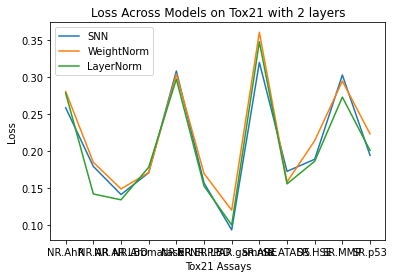

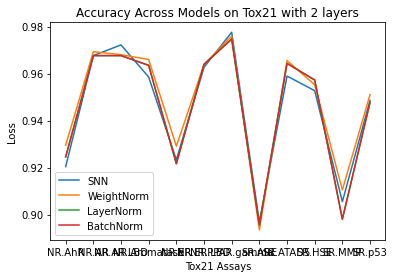

3
Epoch 1/10
76/76 [==============================] - 3s 19ms/step - loss: 0.2873 - accuracy: 0.9069 - val_loss: 0.2189 - val_accuracy: 0.9266
Epoch 2/10
76/76 [==============================] - 1s 12ms/step - loss: 0.2147 - accuracy: 0.9231 - val_loss: 0.2232 - val_accuracy: 0.9270
Epoch 3/10
76/76 [==============================] - 1s 12ms/step - loss: 0.1913 - accuracy: 0.9267 - val_loss: 0.2105 - val_accuracy: 0.9245
Epoch 4/10
76/76 [==============================] - 1s 12ms/step - loss: 0.1687 - accuracy: 0.9341 - val_loss: 0.2253 - val_accuracy: 0.9291
Epoch 5/10
76/76 [==============================] - 1s 12ms/step - loss: 0.1532 - accuracy: 0.9382 - val_loss: 0.2217 - val_accuracy: 0.9279
Epoch 6/10
76/76 [==============================] - 1s 12ms/step - loss: 0.1410 - accuracy: 0.9460 - val_loss: 0.2422 - val_accuracy: 0.9233
Epoch 7/10
76/76 [==============================] - 1s 12ms/step - loss: 0.1334 - accuracy: 0.9452 - val_loss: 0.2316 - val_accuracy: 0.9258
Epoch 8/10


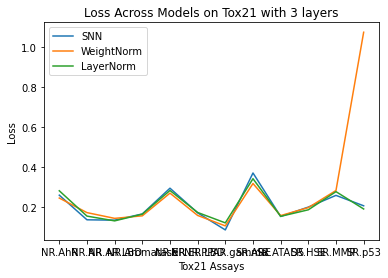

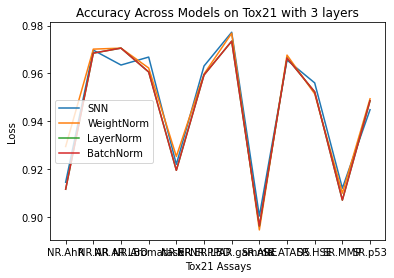

4
Epoch 1/10
76/76 [==============================] - 3s 21ms/step - loss: 0.3053 - accuracy: 0.9040 - val_loss: 0.2150 - val_accuracy: 0.9241
Epoch 2/10
76/76 [==============================] - 1s 13ms/step - loss: 0.2208 - accuracy: 0.9204 - val_loss: 0.2107 - val_accuracy: 0.9283
Epoch 3/10
76/76 [==============================] - 1s 13ms/step - loss: 0.1894 - accuracy: 0.9284 - val_loss: 0.2016 - val_accuracy: 0.9320
Epoch 4/10
76/76 [==============================] - 1s 13ms/step - loss: 0.1787 - accuracy: 0.9320 - val_loss: 0.2042 - val_accuracy: 0.9250
Epoch 5/10
76/76 [==============================] - 1s 13ms/step - loss: 0.1577 - accuracy: 0.9351 - val_loss: 0.2080 - val_accuracy: 0.9337
Epoch 6/10
76/76 [==============================] - 1s 13ms/step - loss: 0.1465 - accuracy: 0.9386 - val_loss: 0.2368 - val_accuracy: 0.9279
Epoch 7/10
76/76 [==============================] - 1s 13ms/step - loss: 0.1436 - accuracy: 0.9396 - val_loss: 0.2215 - val_accuracy: 0.9299
Epoch 8/10


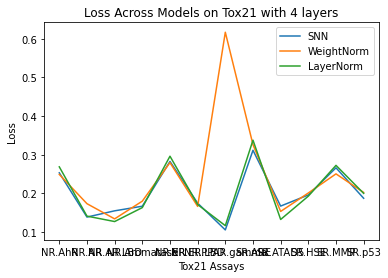

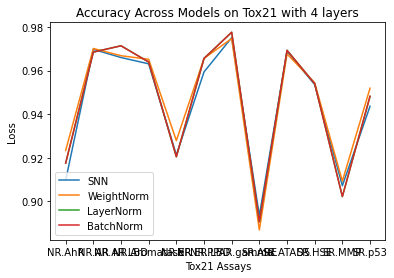

6
Epoch 1/10
76/76 [==============================] - 5s 26ms/step - loss: 0.3004 - accuracy: 0.9051 - val_loss: 0.2188 - val_accuracy: 0.9216
Epoch 2/10
76/76 [==============================] - 1s 15ms/step - loss: 0.2247 - accuracy: 0.9196 - val_loss: 0.2240 - val_accuracy: 0.9221
Epoch 3/10
76/76 [==============================] - 1s 16ms/step - loss: 0.2001 - accuracy: 0.9236 - val_loss: 0.2193 - val_accuracy: 0.9196
Epoch 4/10
76/76 [==============================] - 1s 16ms/step - loss: 0.1839 - accuracy: 0.9280 - val_loss: 0.2239 - val_accuracy: 0.9129
Epoch 5/10
76/76 [==============================] - 1s 15ms/step - loss: 0.1698 - accuracy: 0.9324 - val_loss: 0.2332 - val_accuracy: 0.9146
Epoch 6/10
76/76 [==============================] - 1s 15ms/step - loss: 0.1598 - accuracy: 0.9379 - val_loss: 0.2326 - val_accuracy: 0.9320
Epoch 7/10
76/76 [==============================] - 1s 15ms/step - loss: 0.1450 - accuracy: 0.9406 - val_loss: 0.2512 - val_accuracy: 0.9237
Epoch 8/10


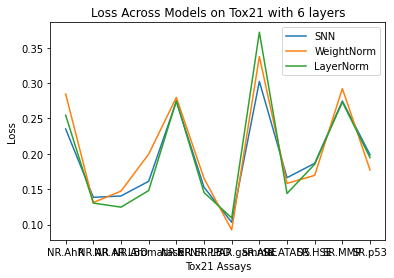

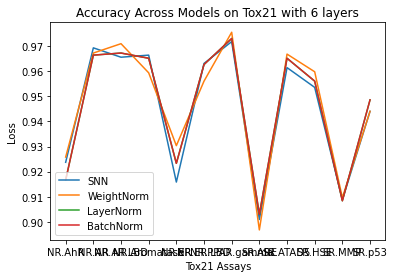

8
Epoch 1/10
76/76 [==============================] - 6s 31ms/step - loss: 0.3195 - accuracy: 0.9062 - val_loss: 0.2283 - val_accuracy: 0.9225
Epoch 2/10
76/76 [==============================] - 1s 18ms/step - loss: 0.2286 - accuracy: 0.9164 - val_loss: 0.2160 - val_accuracy: 0.9254
Epoch 3/10
76/76 [==============================] - 1s 18ms/step - loss: 0.2014 - accuracy: 0.9249 - val_loss: 0.2061 - val_accuracy: 0.9229
Epoch 4/10
76/76 [==============================] - 1s 17ms/step - loss: 0.1823 - accuracy: 0.9245 - val_loss: 0.2165 - val_accuracy: 0.9150
Epoch 5/10
76/76 [==============================] - 1s 18ms/step - loss: 0.1698 - accuracy: 0.9316 - val_loss: 0.2097 - val_accuracy: 0.9196
Epoch 6/10
76/76 [==============================] - 1s 18ms/step - loss: 0.1640 - accuracy: 0.9325 - val_loss: 0.2057 - val_accuracy: 0.9299
Epoch 7/10
76/76 [==============================] - 1s 18ms/step - loss: 0.1535 - accuracy: 0.9368 - val_loss: 0.2067 - val_accuracy: 0.9229
Epoch 8/10


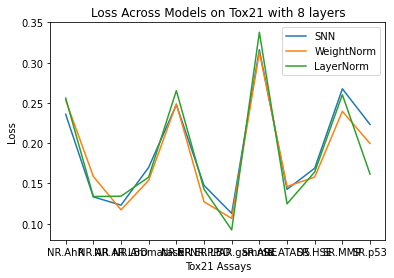

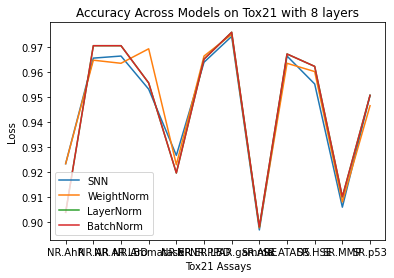

In [16]:
num_layer_list=[2,3,4,6,8]
# Lists to store average accuracies for each model
snn_avg_accuracy = []
weight_avg_accuracy = []
layer_avg_accuracy = []
batch_avg_accuracy = []

import matplotlib.pyplot as plt
for num_layers in num_layer_list:
    print(num_layers)
    targets=[]
    snn_accuracy=[]
    snn_loss=[]
    layer_accuracy=[]
    layer_loss=[]
    weight_accuracy=[]
    weight_loss=[]
    batch_accuracy=[]
    batch_loss=[]
    for target in y_tr.columns:
        targets.append(target)
        # Preprocess the labels for binary classification
        y_tr_binary = y_tr[target].apply(lambda x: 1 if x > 0 else 0).values
        y_te_binary = y_te[target].apply(lambda x: 1 if x > 0 else 0).values

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(x_tr, y_tr_binary, test_size=0.2, random_state=42)

        # Standardize the input features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Convert labels to categorical format
        num_classes = 2  # binary classification
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

        # Create and use the MLPClassifier class
        mlp_classifier = MLPClassifier_weightNormalized(num_layers)
        score = mlp_classifier.train_and_evaluate(X_train, y_train, X_test, y_test)
        weight_loss.append(score[0])
        weight_accuracy.append(score[1])

        mlp_classifier=MLPWithLayerNorm(num_layers)
        score = mlp_classifier.train_and_evaluate(X_train, y_train, X_test, y_test)
        layer_loss.append(score[0])
        layer_accuracy.append(score[1])

        mlp_classifier=MLPWithBatchNorm(num_layers)
        score = mlp_classifier.train_and_evaluate(X_train, y_train, X_test, y_test)
        batch_loss.append(score[0])
        batch_accuracy.append(score[1])

        mlp_classifier=SelfNeuralNetwork(num_layers)
        score = mlp_classifier.train_and_evaluate(X_train, y_train, X_test, y_test)
        snn_accuracy.append(score[1])
        snn_loss.append(score[0])
    # Plotting the lines
    plt.plot(targets, snn_loss, label='SNN')
    plt.plot(targets, weight_loss, label='WeightNorm')
    plt.plot(targets,layer_loss, label='LayerNorm')

    # Adding labels and title
    plt.xlabel('Tox21 Assays')
    plt.ylabel('Loss')
    plt.title(f'Loss Across Models on Tox21 with {num_layers} layers')
    plt.legend()
    plt.show()

    # Plotting the lines
    plt.plot(targets, snn_accuracy, label='SNN')
    plt.plot(targets, weight_accuracy, label='WeightNorm')
    plt.plot(targets,layer_accuracy, label='LayerNorm')
    plt.plot(targets,layer_accuracy, label='BatchNorm')
    # Adding labels and title
    plt.xlabel('Tox21 Assays')
    plt.ylabel('Loss')
    plt.title(f'Accuracy Across Models on Tox21 with {num_layers} layers')
    plt.legend()
    plt.show()

    # Calculate average accuracies for each model
    snn_avg_accuracy.append(sum(snn_accuracy) / len(snn_accuracy))
    weight_avg_accuracy.append(sum(weight_accuracy) / len(weight_accuracy))
    layer_avg_accuracy.append(sum(layer_accuracy) / len(layer_accuracy))
    batch_avg_accuracy.append(sum(batch_accuracy) / len(batch_accuracy))


## Plotting

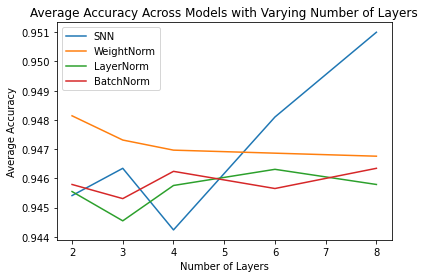

In [27]:
# Plotting the lines for average accuracies
plt.plot(num_layer_list, snn_avg_accuracy, label='SNN')
plt.plot(num_layer_list, weight_avg_accuracy, label='WeightNorm')
plt.plot(num_layer_list, layer_avg_accuracy, label='LayerNorm')
plt.plot(num_layer_list, batch_avg_accuracy, label='BatchNorm')

# Adding labels and title
plt.xlabel('Number of Layers')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy Across Models with Varying Number of Layers')
plt.legend()
plt.show()

As the number of layers increases, SNN improves its performance more than the other models